In [1]:
%qtconsole
%load_ext autoreload
%autoreload 2
%load_ext ipycache

In [2]:
import sys
sys.path.append('/home/jfear/devel/GalaxyTools')

In [3]:
from baPlot import *
%matplotlib inline

Grab the command line options

In [25]:
myopts = ['--input', '/home/jfear/sandbox/secim/data/ST000015_log.tsv',
          '--design', '/home/jfear/sandbox/secim/data/ST000015_design.tsv',
          '--ID', 'Name',
          '--group', 'treatment',
          '--ba', '/home/jfear/sandbox/secim/data/test_ba.pdf',
          '--flag_dist', '/home/jfear/sandbox/secim/data/test_dist.pdf',
          '--flag_summary', '/home/jfear/sandbox/secim/data/test_flag_summary.tsv',
          '--debug']

args = getOptions(myopts=myopts)


Create a class for handling Flags

In [26]:
dat = wideToDesign(args.fname, args.dname, args.uniqID, args.group)

if args.processOnly:
    toProcess = dat.design[dat.design[args.group].isin(args.processOnly)].index
else:
    toProcess = dat.sampleIDs
    
wide = dat.wide.loc[:, toProcess]

# Create a FlagOutlier object to store all flags
flags = FlagOutlier(dat.wide.index)

# Open a multiple page PDF for plots
ppBA = PdfPages(args.baName)

In [27]:
# Grab group
grp = dat.design.groupby(dat.group)
i = '09_uM_palmita'
val = grp.get_group(i)
#val = dat.design

# Create combos
combos = list(combinations(val.index, 2))

In [29]:
%%cache ba_flags.pkl flags --force

iterateCombo(wide, combos, ppBA, flags, args.cutoff, group=i)

[Saved variables flags to file '/home/jfear/devel/GalaxyTools/notebook/ba_flags.pkl'.]


/usr/lib/pymodules/python2.7/matplotlib/backends/backend_pdf.py:2184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


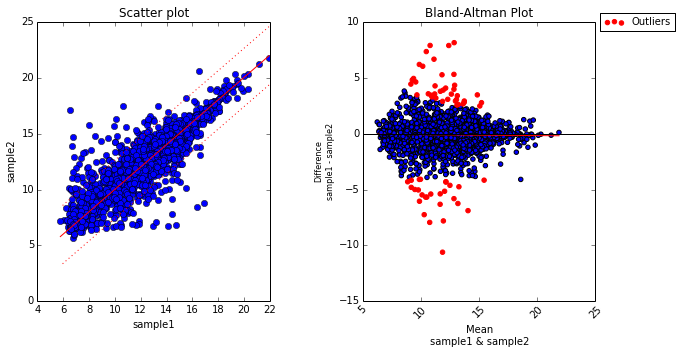

In [16]:
combo = combos[0]
data = wide
out = ppBA
cutoff = 3

rows = data.shape[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
fig.subplots_adjust(wspace=0.4)
subset = data.loc[:, [combo[0], combo[1]]]

# Drop missing value
subset.dropna(inplace=True)
missing = rows - subset.shape[0]

# Set X's and Y's
x, y = subset.iloc[:, 0], subset.iloc[:, 1]
x.name = 'sample1'
y.name = 'sample2'

# Scatter Plot
ax1 = makeScatter(x, y, ax1)

# BA plot
ax2, outlier = makeBA(x, y, ax2, cutoff)
fig.savefig('/home/jfear/devel/GalaxyTools/images/ba_plot.png', bbox_inches='tight')

In [39]:
low, up, fit, resid, infl = runRegression(x, y)

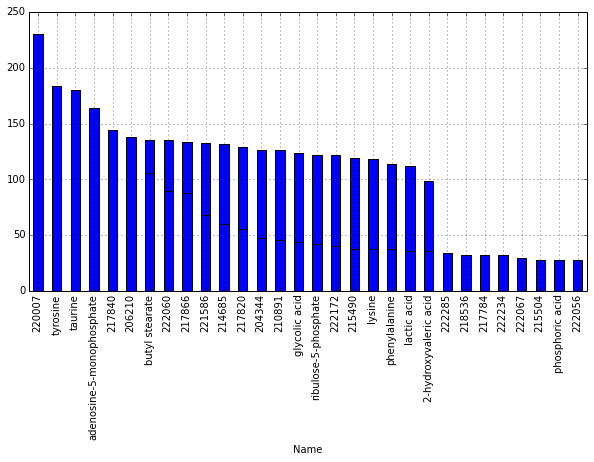

In [31]:
summary = flags.summarizeSampleFlags(wide)
plotFlagDist(summary, args.distName)

In [34]:
# Sum flags across samples
col_sum = summary.sum(axis=0)
col_sum.sort(ascending=False)

# Sum flags across compounds
row_sum = summary.sum(axis=1)
row_sum.sort(ascending=False)

# How many flags could I have
row_max, col_max = summary.shape

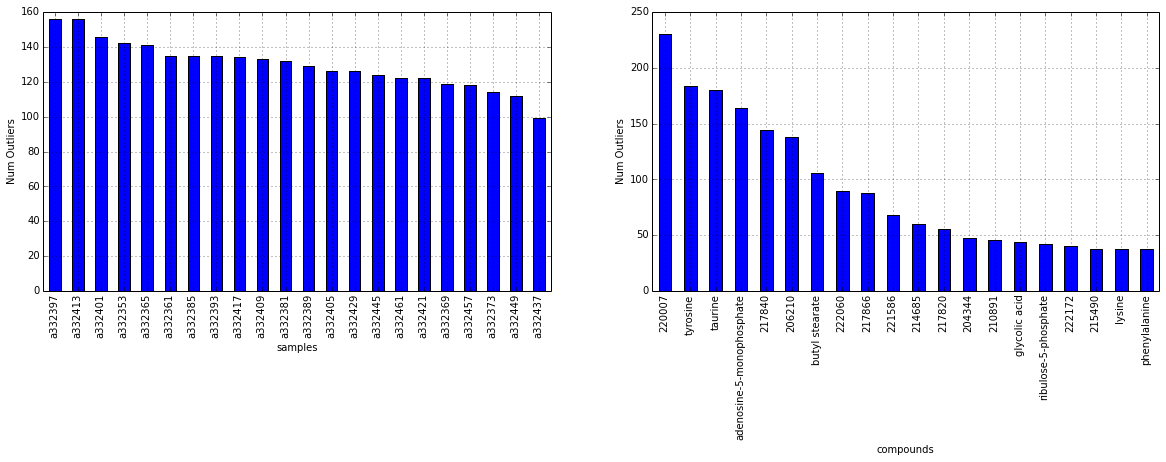

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

col_sum[col_sum > 0].plot(kind='bar', ax=ax1)
row_sum[row_sum > 0].head(20).plot(kind='bar', ax=ax2)
ax1.set_xlabel('samples'); ax2.set_xlabel('compounds')
ax1.set_ylabel('Num Outliers'); ax2.set_ylabel('Num Outliers')
fig.savefig('/home/jfear/devel/GalaxyTools/images/ba_plot_outlier_dist.png')